<a href="https://colab.research.google.com/github/khalidmahamud/QML/blob/main/QML_quantum_nodes_into_torch_layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons

import torch
import torch.nn as nn

## Loading the dataset

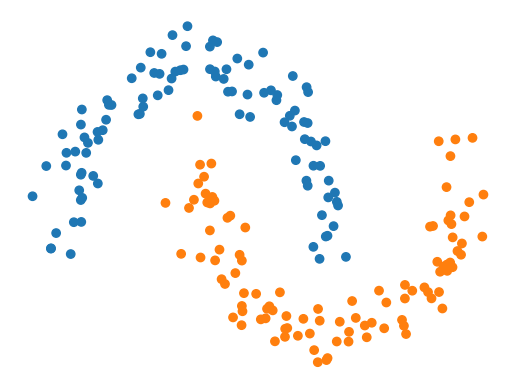

In [ ]:
# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

X, y = make_moons(n_samples=200, noise=0.1)
y_ = torch.unsqueeze(torch.tensor(y), 1)  # used for one-hot encoded labels
y_hot = torch.scatter(torch.zeros((200, 2)), 1, y_, 1)

c = ["#1f77b4" if y_ == 0 else "#ff7f0e" for y_ in y]  # colours for each class
plt.axis("off")
plt.scatter(X[:, 0], X[:, 1], c=c)
plt.show()

In [ ]:
!pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 53.8 MB/s eta 0:00:00


## Defining a QNode

In [ ]:
import pennylane as qml

n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

## Interfacing with Keras

In [ ]:
n_layers = 6
weight_shapes = {"weights": (n_layers, n_qubits)}

## Creating a Hybrid Model
- A 2-neuron fully connected classical layer
- Our 2-qubit QNode converted into a layer
- Another 2-neuron fully connected classical layer
- A softmax activation to convert to a probability vector


In [ ]:
class HybridModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.clayer_1 = nn.Linear(2, 2)
    self.qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)
    self.clayer_2 = nn.Linear(2, 2)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    x = self.clayer_1(x)
    x = self.qlayer(x)
    x = self.clayer_2(x)
    return self.softmax(x)

model = HybridModel()

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
loss_fn = nn.L1Loss()

In [ ]:
X_tensor = X.clone().detach().requires_grad_(True)
y_hot = y_hot.float()

# batch_size = 5
# batches = 200 // batch_size

# data_loader = torch.utils.data.DataLoader(
#     list(zip(X, y_hot)), batch_size=5, shuffle=True, drop_last=True
# )

epochs = 1000
losses = np.zeros(epochs)

for epoch in range(epochs):
  # forward pass
  y_hat = model(X)

  # compute loss
  loss = loss_fn(y_hat, y_hot)
  losses[epoch] = loss.item()

  # back pass
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if epoch % 100 == 0:
    print("Average loss over epoch {}: {:.4f}".format(epoch, loss))

y_pred = model(X)
predictions = torch.argmax(y_pred, axis=1).detach().numpy()

correct = [1 if p == p_true else 0 for p, p_true in zip(predictions, y)]
accuracy = 100 * sum(correct) / len(correct)
print(f"Accuracy: {accuracy}%")

Average loss over epoch 0: 0.1450
Average loss over epoch 100: 0.1444
Average loss over epoch 200: 0.1439
Average loss over epoch 300: 0.1435
Average loss over epoch 400: 0.1431
Average loss over epoch 500: 0.1427
Average loss over epoch 600: 0.1423
Average loss over epoch 700: 0.1420
Average loss over epoch 800: 0.1417
Average loss over epoch 900: 0.1414
Accuracy: 86.5%


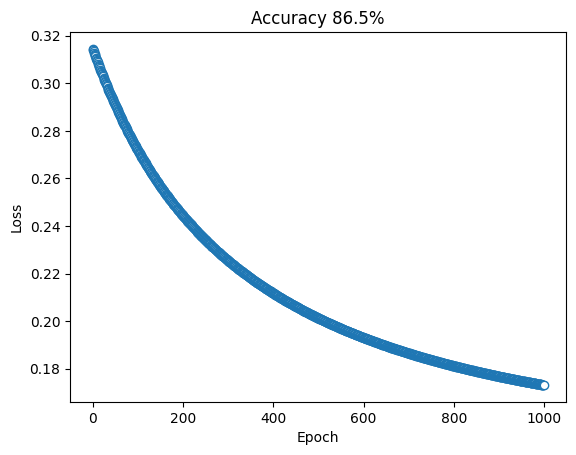

In [ ]:
# show the losses

plt.plot(losses, 'o', markerfacecolor='w', linewidth=.1)
plt.title("Accuracy %g%%" %accuracy)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()